In [4]:
import cdms2 as cdms
import MV2 as MV
import cdtime,cdutil,genutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import string
import glob
import scipy.stats as stats
# Local solution
# If running remotely, uncomment the following code:
# %%bash
# git clone https://github.com/katemarvel/CMIP5_tools
# import CMIP5_tools as cmip5
import sys,os
sys.path.append("/Users/kmarvel/Google Drive/python-utils")

import CMIP5_tools as cmip5
import DA_tools
import Plotting

from eofs.cdms import Eof
from eofs.multivariate.cdms import MultivariateEof
%matplotlib inline

In [5]:
def get_ok_models(variable,region):

    models={}
    #readstem="/Users/kmarvel/Documents/DATA/dester/regional_averages/"
    #readstem = "/Volumes/SahelData/CMIP6Drought/NCA4/"
    readstem = "/Users/kmarvel/Documents/DATA/dester/regional_averages/NCA4/"
    experiments=[x.split("/")[-1] for x in glob.glob(readstem+region+"/"+variable+"/*")]
    for experiment in experiments:
        readdirec=readstem+region+"/"+variable+"/"+experiment+"/"
        rips=[x.split(".")[3] for x in glob.glob(readdirec+"*")]
        models[experiment]=np.unique([x.split(".")[2] for x in glob.glob(readdirec+"*")])
    okmodels=models[experiments[0]]
    for experiment in experiments[1:]: 
        #
        okmodels=np.intersect1d(okmodels,models[experiment])
    return okmodels


def commonElements(arr): 
      
    # initialize result with first array as a set 
    result = set(arr[0]) 
  
    # now iterate through list of arrays starting from 
    # second array and take intersection_update() of  
    # each array with result. Every operation will  
    # update value of result with common values in 
    # result set and intersected set 
    for currSet in arr[1:]: 
        result.intersection_update(currSet) 
  
    return list(result) 

#Get ensemble
#for model in okmodels:
def get_ensemble_dictionary(variable,region,exclude_piC=True):
    okmodels=get_ok_models(variable,region)
    EXPS={}
    #readstem = "/Volumes/SahelData/CMIP6Drought/NCA4/"
    readstem = "/Users/kmarvel/Documents/DATA/dester/regional_averages/NCA4/"
    histfut=[x.split("/")[-1] for x in glob.glob(readstem+region+"/"+variable+"/*")]
    if exclude_piC:
        histfut.remove("piControl")
    for experiment in histfut:
        ENSEMBLE={}

        readdirec=readstem+region+"/"+variable+"/"+experiment+"/"
        for model in okmodels:
            ENSEMBLE[model]=sorted([x.split(".")[3] for x in glob.glob(readdirec+"*"+model+"*")])
        EXPS[experiment]=ENSEMBLE
    
    return EXPS

def get_common_ensembles(variable,region):
    OK={}
    EXPS=get_ensemble_dictionary(variable,region)
    #readstem = "/Volumes/SahelData/CMIP6Drought/NCA4/"
    readstem = "/Users/kmarvel/Documents/DATA/dester/regional_averages/NCA4/"
    histfut=[x.split("/")[-1] for x in glob.glob(readstem+region+"/"+variable+"/*")]
    
    histfut.remove("piControl")


    for model in get_ok_models(variable,region):
        OK[model]=sorted(commonElements([EXPS[x][model] for x in histfut]))
    return OK

def get_ensemble_filenames(variable,region,experiment):
    fnames=[]
    if experiment != "piControl":
        OK=get_common_ensembles(variable,region)
    else:
        OK=get_ensemble_dictionary(variable,region,exclude_piC=False)["piControl"]
    #readstem = "/Volumes/SahelData/CMIP6Drought/NCA4/"
    readstem = "/Users/kmarvel/Documents/DATA/dester/regional_averages/NCA4/"
    readdirec=readstem+region+"/"+variable+"/"+experiment+"/"
    for model in sorted(OK.keys()):
        for rip in sorted(OK[model]):
            fname=variable+"."+experiment+"."+model+"."+rip+".nc"
            fnames+=[readdirec+fname]
    return fnames
            
def get_color(scenario):
    d={}
    d["ssp585"]="#d62728"
    d["ssp370"]="#ff7f0e"
    d["ssp245"]="#2ca02c"
    d["ssp126"]="#1f77b4"
    d["historical"]="#8c564b"
    d["piControl"]="#9467bd"
    if scenario in d.keys():
        return d[scenario]
    else:
        return "k"
def get_label(scenario):
    d={}
    d["ssp585"]="SSP5-8.5"
    d["ssp370"]="SSP3-7.0"
    d["ssp245"]="SSP2-4.6"
    d["ssp126"]="SSP1-2.6"
    d["historical"]="historical"
    d["piControl"]="piControl"
    if scenario in d.keys():
        return d[scenario]
    else:
        return "--"

def bootstrap_slopes(noise,L):
    nt=noise.shape[0]-L
    test = MV.zeros((nt,L))
    
    for i in range(nt):
        test[i]=noise[i:L+i]
    test.setAxis(1,noise[:L].getAxis(0))
    return cmip5.get_linear_trends(test)


def fast_slopes(noise,L):
#L=30
    ntrends=int(noise.shape[0]/L)
    trunc=noise[:L*ntrends]
    tax=noise[:L].getTime()
    fast=trunc.reshape(ntrends,L)
    fast.setAxis(1,tax)
    return(cmip5.get_linear_trends(fast))

def get_model_colors(model,cmap=cm.tab10):
#     model_names=(    'AWI-CM-1-1-MR',	
#                  'BCC-CSM2-MR',		
#                  'BCC-ESM1',
#                  'CAMS-CSM1-0',      # NEED TO REDO
#                  'CanESM5',			
#                  'CESM2',			
#                  'CESM2-WACCM',		
#                  'CNRM-CM6-1',		
#                  'CNRM-ESM2-1',		
#                  'E3SM-1-0',		
#                  'EC-Earth3',       # NEED TO REDO
#                  'EC-Earth3-LR',    # NEED TO REDO
#                  'EC-Earth3-Veg',   # NEED TO REDO
#                  'FGOALS-f3-L',     # NEED TO REDO
#                  'GFDL-AM4', 
#                  'GFDL-CM4',  # PI CONTROL PROBLEMS		
#                  'GFDL-ESM4',		
#                  'GISS-E2-1-G',		
#                  'GISS-E2-1-H',		
#                  'HadGEM3-GC31-LL',
#                  'IPSL-CM6A-LR',	 
#                  'MIROC6',			# mrsos and tas done
#                  'MIROC-ES2L',
#                  'MPI-ESM1-2-HR',   
#                  'MRI-ESM2-0',       # mrsos and tas done
#                  'NESM3',             # mrsos and tas done
#                  'SAM0-UNICON',		# mrsos and tas done
#                  'UKESM1-0-LL',	    # mrsos and tas done
#               )
    model_names=np.array(['BCC-CSM2-MR', 'CESM2', 'CESM2-WACCM', 'CNRM-CM6-1', 'CNRM-ESM2-1',
       'CanESM5', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6',
       'MRI-ESM2-0', 'UKESM1-0-LL'], dtype='<U12')
    L=float(len(model_names))
    d={}
    for i in range(int(L)):
        numerator=float(np.mod(i,10))
        d[model_names[i]]=cmap(numerator/10.)
    return d[model]
    
def get_model_ls(model):
#     model_names=(    'AWI-CM-1-1-MR',	
#                  'BCC-CSM2-MR',		
#                  'BCC-ESM1',
#                  'CAMS-CSM1-0',      # NEED TO REDO
#                  'CanESM5',			
#                  'CESM2',			
#                  'CESM2-WACCM',		
#                  'CNRM-CM6-1',		
#                  'CNRM-ESM2-1',		
#                  'E3SM-1-0',		
#                  'EC-Earth3',       # NEED TO REDO
#                  'EC-Earth3-LR',    # NEED TO REDO
#                  'EC-Earth3-Veg',   # NEED TO REDO
#                  'FGOALS-f3-L',     # NEED TO REDO
#                  'GFDL-AM4', 
#                  'GFDL-CM4',  # PI CONTROL PROBLEMS		
#                  'GFDL-ESM4',		
#                  'GISS-E2-1-G',		
#                  'GISS-E2-1-H',		
#                  'HadGEM3-GC31-LL',
#                  'IPSL-CM6A-LR',	 
#                  'MIROC6',			# mrsos and tas done
#                  'MIROC-ES2L',
#                  'MPI-ESM1-2-HR',   
#                  'MRI-ESM2-0',       # mrsos and tas done
#                  'NESM3',             # mrsos and tas done
#                  'SAM0-UNICON',		# mrsos and tas done
#                  'UKESM1-0-LL',	    # mrsos and tas done
#               )
    #model_names=get_ok_models("tas","SW")
    model_names=np.array(['BCC-CSM2-MR', 'CESM2', 'CESM2-WACCM', 'CNRM-CM6-1', 'CNRM-ESM2-1',
       'CanESM5', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6',
       'MRI-ESM2-0', 'UKESM1-0-LL'], dtype='<U12')
    L=int(len(model_names))
    d={}
    for i in range(int(L)):
        if i in np.arange(0,L/4):
            d[model_names[i]]="solid"
        elif i in np.arange(L/4,L/2):
            d[model_names[i]]="dotted"
        elif i in np.arange(L/2,3*L/4):
            d[model_names[i]]="dashed"
        else:
            d[model_names[i]]="dashdot"
        
        
    return d[model]

In [6]:
mods=get_ok_models("mrros","SW")
variables=["tas","mrro","mrros","mrso","mrsos","pr","evspsbl"]
for variable in variables:
    mods=np.union1d(mods,np.array(get_ok_models(variable,"SW")))
mods

array(['BCC-CSM2-MR', 'CESM2', 'CESM2-WACCM', 'CNRM-CM6-1', 'CNRM-ESM2-1',
       'CanESM5', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6',
       'MRI-ESM2-0', 'UKESM1-0-LL'], dtype='<U12')

In [7]:
NCA4regions={}
#Northwest (NW): (125°W–111°W, 42°N–49°N)
NCA4regions["NW"]=cdutil.region.domain(longitude=(-125,-111),latitude=(42,49))
#Southwest (SW): (124°W–102°W, 31°N–42°N)
NCA4regions["SW"]=cdutil.region.domain(longitude=(-124,-102),latitude=(31,42))
#Upper Great Plains (GPu): (116°W–95°W, 40°N–49°N)
NCA4regions["GPu"]=cdutil.region.domain(longitude=(-116,-95),latitude=(40,49))
#Lower Great Plains (GPl): (107°W–93°W, 26°N–40°N)
NCA4regions["GPl"]=cdutil.region.domain(longitude=(-107,-93),latitude=(26,40))
#Midwest (MW): (97°W–80°W, 36°N–50°N)
NCA4regions["MW"]=cdutil.region.domain(longitude=(-97,-80),latitude=(36,50))
#Northeast (NE): (82°W–67°W, 37°N–48°N)
NCA4regions["NE"]=cdutil.region.domain(longitude=(-82,-67),latitude=(37,48))
#Southeast (SE): (95°W–76°W, 25°N–39°N)
NCA4regions["SE"]=cdutil.region.domain(longitude=(-95,-76),latitude=(25,39))

#regions["central_plains"]=cdutil.region.domain(longitude=(-105,-92),latitude=(32,46))
#regions["southwest"]=cdutil.region.domain(longitude=(-125,-105),latitude=(32,41))



In [83]:
class TOE():
    def __init__(self,variable,region):
        self.variable=variable
        self.region=region
        self.ensemble_dict=get_common_ensembles(variable,region)
        self.readstem = "/Users/kmarvel/Documents/DATA/dester/regional_averages/NCA4/"
    def get_ensemble(self,experiment):
        if not hasattr(self,experiment):
            fnames=get_ensemble_filenames(self.variable,self.region,experiment)
            nfiles=len(fnames)
            i=0
            fil=fnames[i]
            f=cdms.open(fil)
            data=f(self.variable)
            tax=data.getTime()
            ntime=len(tax)
            alldata=MV.zeros((nfiles,ntime))+1.e20
            alldata[i]=data
            f.close()
            for i in range(nfiles)[1:]:
                fil=fnames[i]
                f=cdms.open(fil)
                data=f(self.variable)
                if len(data.getTime())==ntime:
                    alldata[i]=data
                f.close()
        
            alldata.setAxis(1,tax)    
            modax=cmip5.make_model_axis(fnames)
            alldata.setAxis(0,modax)
            setattr(self,experiment,MV.masked_where(np.abs(alldata)>1.e10,alldata))
    def ensemble_average(self,experiment):
        self.get_ensemble(experiment)
        data=getattr(self,experiment)
        nens,ntime=data.shape
        models=sorted(self.ensemble_dict.keys())
        nmod=len(models)
        EnsembleAverage=np.ma.zeros((nmod,ntime))
        fnames=get_ensemble_filenames(self.variable,self.region,experiment)
        counter=0
        for model in models:
            fnames=np.array(get_ensemble_filenames(self.variable,self.region,experiment))
            I=np.where([x.split(".")[2]==model for x in fnames])[0]
            EnsembleAverage[counter]=np.ma.average(data.asma()[I],axis=0)
            counter+=1
        EnsembleAverage=MV.array(EnsembleAverage)
        EnsembleAverage.setAxis(1,data.getTime())
        modax=cmip5.make_model_axis(models)
        EnsembleAverage.setAxis(0,modax)
        cdutil.setTimeBoundsMonthly(EnsembleAverage)            
        return EnsembleAverage

       

    def single_member_ensemble(self,experiment):
        """Get a single member from each ensemble"""
        self.get_ensemble(experiment)
        data=getattr(self,experiment)
        nens,ntime=data.shape
        models=sorted(self.ensemble_dict.keys())
        nmod=len(models)
        SingleMember=np.ma.zeros((nmod,ntime))
        fnames=sorted(get_ensemble_filenames(self.variable,self.region,experiment))
        counter=0
        for model in models:
            fnames=np.array(get_ensemble_filenames(self.variable,self.region,experiment))
            I=np.where([x.split(".")[2]==model for x in fnames])[0]
            first_member=I[0]
            SingleMember[counter]=data.asma()[first_member]
            counter+=1
        SingleMember=MV.array(SingleMember)
        SingleMember.setAxis(1,data.getTime())
        modax=cmip5.make_model_axis(models)
        SingleMember.setAxis(0,modax)
        cdutil.setTimeBoundsMonthly(SingleMember)  
        return SingleMember
    
    def splice_historical(self,ssp,single_member=True):
        #concatenate hist and future
        if single_member:
            func=self.single_member_ensemble
        else:
            func=self.ensemble_average
        hist=func("historical")
        all_data=MV.concatenate((hist,func(ssp)),axis=1)
        tax=cdms.createAxis(np.arange(all_data.shape[1]))
        tax.units=hist.getTime().units
        tax.id='time'
        tax.designateTime()
        all_data.setAxis(1,tax)
        cdutil.setTimeBoundsMonthly(all_data)
        all_data.setAxis(0,hist.getAxis(0))
        all_data.id=hist.id
        cdutil.setTimeBoundsMonthly(all_data)
        return all_data
        
    def plot_future(self,season,single_member=True,plot_historical=True):
        if single_member:
            func=self.single_member_ensemble
        else:
            func=self.ensemble_average
        hist=func("historical")
        
        start_time=cdtime.comptime(1951,1,1)
        end_time=cdtime.comptime(1980,12,31)
        clim = getattr(cdutil,season).climatology(hist(time= (start_time, end_time, 'co')))
        if plot_historical:
            timedata=getattr(cdutil,season).departures(hist,ref=clim)
            Plotting.time_plot(MV.average(timedata,axis=0),color=get_color("historical"),label=get_label("historical"))
        for ssp in ["ssp126","ssp245","ssp370","ssp585"]:
            rawdata=func(ssp)
            timedata=getattr(cdutil,season).departures(rawdata,ref=clim)
            Plotting.time_plot(MV.average(timedata,axis=0),color=get_color(ssp),label=get_label(ssp))
        plt.legend()
    def signals(self,season,ssp,single_member=True,start_time=None,init=10):
        if start_time is None:
            start_time=cdtime.comptime(1980,1,1)
        end_time=cdtime.comptime(2100,12,31)
        trend_end=start_time.add(init,cdtime.Years)
        if single_member:
            func=self.single_member_ensemble
        else:
            func=self.ensemble_average
        all_data=self.splice_historical(ssp,single_member=single_member)
        hist=func("historical")
        
        

        #define the anomaly base period
        clim_start_time=cdtime.comptime(1951,1,1)
        clim_end_time=cdtime.comptime(1980,12,31)
        clim = getattr(cdutil,season).climatology(hist(time= \
                                                       (clim_start_time, \
                                                        clim_end_time, 'co')))
        #get seasonal anomalies
        seasonal_data=getattr(cdutil,season).departures(all_data,ref=clim)
        #set up array for signals
        nmod,nyears=seasonal_data.shape
        tax=seasonal_data(time=(trend_end,end_time)).getTime()
        nsig=len(tax)
        signals=MV.zeros((nmod,nsig))
        #calculate signals
        counter=0
        while trend_end.cmp(end_time)<0:
            signals[:,counter]=cmip5.get_linear_trends(seasonal_data(time=(start_time,trend_end)))
            trend_end=trend_end.add(1,cdtime.Years)
            counter+=1
        signals.setAxis(0,hist.getAxis(0))
        signals.setAxis(1,tax)
        return signals

    def concatenate_piControl(self,season=None,compressed=False):
        experiment="piControl"
        fnames=sorted(get_ensemble_filenames(self.variable,self.region,experiment))
        models=sorted(self.ensemble_dict.keys())
        
        nmod=len(models)
        ntimes=[]
        model_names=[]
        #Loop over without loading data to figure out the shortest length control run
        for model in models:
            
            I=np.where([x.split(".")[2]==model for x in fnames])[0]

            first_member=int(I[0])
       
            fname=fnames[first_member]
          
            model_names+=[fname]
            f=cdms.open(fname)
            ntimes+=[int(f[self.variable].shape[0])]
            f.close()
        L=np.min(ntimes)
        #Set the time axis to be the time axis of the shortest control rin
        imin=np.argmin(ntimes)

        fshortest=model_names[imin]
        f=cdms.open(fshortest)
        tax=f(self.variable).getTime()
        tax.id='time'
        tax.designateTime()
        f.close()
        #Load data
        SingleMember=np.ma.zeros((nmod,L))
        i=0
        for model in models:
            I=np.where([x.split(".")[2]==model for x in fnames])[0]
            first_member=I[0]
            fname=fnames[first_member]
            f=cdms.open(fname)
            SingleMember[i]=f(self.variable)[:L]
            i+=1
            f.close()
        
        #Historical units are already converted; need to convert piControl from 
        #kg m-2 s-1 to mm day-1
        if self.variable in ["pr","evspsbl","prsn","mrros","mrro"]:
            SingleMember = SingleMember*86400.
        SingleMember=MV.array(SingleMember)
        SingleMember.setAxis(1,tax)
        SingleMember.setAxis(0,cmip5.make_model_axis(model_names))
        ###KLUDGE: FIRST YEAR IS ZERO- FIX THIS IN DOWNLOADER
        SingleMember=MV.masked_where(SingleMember==0,SingleMember)
        if season is None:
            return SingleMember
        cdutil.setTimeBoundsMonthly(SingleMember)
        seasonal=getattr(cdutil,season).departures(SingleMember)
        
        return DA_tools.concatenate_this(seasonal,compressed=compressed)
    
    def get_signal_to_noise(self,season,ssp,start_time,stop_time):
        data=self.splice_historical(ssp)(time=(start_time,stop_time))
        seasdata=getattr(cdutil,season).departures(data)
        piCdata=self.concatenate_piControl(season)
        signals=cmip5.get_linear_trends(seasdata)
        L=len(seasdata.getTime())
        noise=bootstrap_slopes(piCdata,L)
        return signals,noise
    def average_SN_end_century(self,season,ssp='ssp585'):
        start_time=cdtime.comptime(1980,1,1)
        stop_time=cdtime.comptime(2100,12,31)
        signals,noise=self.get_signal_to_noise(season,ssp,start_time,stop_time)
        return np.average(signals)/np.std(noise)
        
    def noise(self,season,start_time=None,init=10):
        sigmas=[]
        if start_time is None:
            start_time=cdtime.comptime(1980,1,1)
        end_time=cdtime.comptime(2100,12,31)
        trend_end=start_time.add(init,cdtime.Years)
        
        nsig=end_time.year-trend_end.year+1
        concatenated=self.concatenate_piControl(season)
        Ls=np.arange(nsig)+init
        for L in Ls:
            distr=bootstrap_slopes(concatenated,L)
            #distr=fast_slopes(concatenated,L)
            sigmas+=[np.std(distr)]
        sigmas=MV.array(sigmas)
        tax=cdms.createAxis(np.arange(nsig)+init+start_time.year)
        tax.id='time'
        tax.units='years since '+str(start_time)
        sigmas.setAxis(0,tax)
        return sigmas
        
    def plot_signal_to_noise(self,season,single_member=True,start_time=None,init=10):
        SNS={}
        noise=self.noise(season,start_time=start_time,init=init)
        for ssp in ["ssp126","ssp245", "ssp370","ssp585"]:
            signals=self.signals(season,ssp,start_time=start_time,init=init)
            SN=cmip5.cdms_clone(signals.asma()/noise.asma(),signals)
            SNS[ssp]=SN
            Plotting.time_plot(MV.average(SN,axis=0),label=get_label(ssp),color=get_color(ssp))
            plt.xlabel("Trend End Year (assuming 1980 start)")
            plt.ylabel(self.variable+" S/N")
            
        return SNS
            
            
   

In [84]:
mrros_sw=TOE("mrros","SW")  
self=mrros_sw

In [85]:

np.abs(self.average_SN_end_century("MAM"))>

/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/numpy/ma/core.py:3201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


-4.448758942795048

In [96]:
regions=list(NCA4regions.keys())
variables=["tas","mrro","mrros","mrso","mrsos","pr","evspsbl"]
RegionalCheck={}
for region in regions:
    print(region)
    RegionalCheck[region]={}
    for variable in variables:
        print(variable)
        X=TOE(variable,region)
        RegionalCheck[region][variable]={}
        for season in ["DJF","MAM","JJA","SON"]:
            RegionalCheck[region][variable][season]=X.average_SN_end_century(season)

NW
tas


/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/numpy/ma/core.py:3201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


mrro
mrros
mrso
mrsos
pr
evspsbl
SW
tas
mrro
mrros
mrso
mrsos
pr
evspsbl
GPu
tas
mrro
mrros
mrso
mrsos
pr
evspsbl
GPl
tas
mrro
mrros
mrso
mrsos
pr
evspsbl
MW
tas
mrro
mrros
mrso
mrsos
pr
evspsbl
NE
tas
mrro
mrros
mrso
mrsos
pr
evspsbl
SE
tas
mrro
mrros
mrso
mrsos
pr
evspsbl


In [102]:
RegionalCheck["NW"]
import pickle
f=open("regionalcheck.dat","wb")
pickle.dump(RegionalCheck,f)
f.close()

In [105]:
f=open("regionalcheck.dat","rb")
test=pickle.load(f)
f.close
test["NE"]

{'tas': {'DJF': 16.81438649383611,
  'MAM': 16.104855240710336,
  'JJA': 24.09452552507728,
  'SON': 20.81795994587114},
 'mrro': {'DJF': 4.920053669233847,
  'MAM': 0.4662393173254963,
  'JJA': -0.4222840651755732,
  'SON': -0.1779155390878343},
 'mrros': {'DJF': -0.08296039545884576,
  'MAM': -2.2051525543268875,
  'JJA': 0.28862078001110775,
  'SON': 0.9146904695082368},
 'mrso': {'DJF': 0.723817119635367,
  'MAM': 0.017413696923576315,
  'JJA': -1.1291616046372117,
  'SON': -1.5403230188088668},
 'mrsos': {'DJF': -9.03930045145815,
  'MAM': -7.554063500007072,
  'JJA': -2.9479444762424554,
  'SON': -3.6076121010336717},
 'pr': {'DJF': 8.47814385223914,
  'MAM': 6.831280001289179,
  'JJA': 0.4152040094218273,
  'SON': 1.6281691138023724},
 'evspsbl': {'DJF': 22.83557701057518,
  'MAM': 16.50052208577384,
  'JJA': 12.562225190291398,
  'SON': 17.473273059195904}}

In [72]:
start_time=cdtime.comptime(1980,1,1)
stop_time=cdtime.comptime(2099,12,31)
ssp="ssp585"
season="MAM"
data=self.splice_historical(ssp)(time=(start_time,stop_time))
seasdata=getattr(cdutil,season).departures(data)
piCdata=self.concatenate_piControl(season)
signals=cmip5.get_linear_trends(seasdata)
L=len(seasdata.getTime())
noise=bootstrap_slopes(piCdata,L)

In [76]:
signals2,noise2=mrros_sw.get_signal_to_noise(season,ssp,start_time,stop_time)

/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/numpy/ma/core.py:3201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


-4.425204840946636

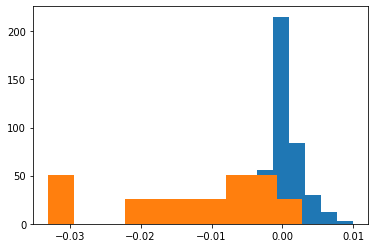

In [82]:
tmp=plt.hist(noise,density=True)
tmp=plt.hist(signals,density=True)
np.average(signals)/np.std(noise)

/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/numpy/ma/core.py:3201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


AttributeError: 'TOE' object has no attribute 'sigmas'

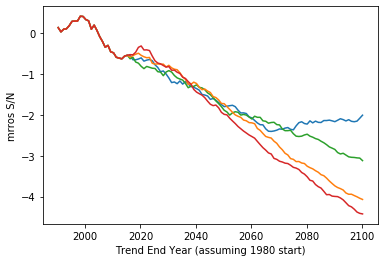

In [15]:
mrros_sw=TOE("mrros","SW")   
SNS=mrros_sw.plot_signal_to_noise("MAM")


In [18]:
NCA4regions.keys()

dict_keys(['NW', 'SW', 'GPu', 'GPl', 'MW', 'NE', 'SE'])

In [17]:
variables=["pr","evspsbl","mrro","mrros","mrso","mrsos","tas"]
#variables=["mrsos","tas"]
seasons=["DJF","MAM","JJA","SON"]
writedirec="~/Documents/DATA/DroughtSN/"
for variable in variables:
    for region in NCA4regions.keys():
        
        X=TOE(variable,region)
        for season in seasons:
            plt.figure()
            SN=X.plot_signal_to_noise(season)
            plt.title("Central Plains ("+season+")")
            plt.savefig(variable+".central_plains."+season+".SN.png")
            writehere=writedirec+"central_plains/"
            for ssp in SN_CP.keys():
                data=SN_CP[ssp]
                data.id=variable+"_SN"

                writefname=variable+"."+ssp+".central_plains."+season+".SN.nc"
                fw=cdms.open(writehere+writefname,"w")
                fw.write(data)
                fw.close()


            plt.clf()

            #plt.figure()
            SN_SW=SW.plot_signal_to_noise(season)
            plt.title("Southwest ("+season+")")
            plt.savefig(variable+".southwest."+season+".SN.png")
            writehere=writedirec+"southwest/"
            for ssp in SN_SW.keys():
                data=SN_SW[ssp]
                data.id=variable+"_SN"

                writefname=variable+"."+ssp+".southwest."+season+".SN.nc"
                fw=cdms.open(writehere+writefname,"w")
                fw.write(data)
                fw.close()




            plt.clf()

        

SyntaxError: invalid syntax (<ipython-input-17-9183998feec6>, line 4)

In [427]:
def set_up_axis():
    fig3=plt.figure(figsize=(20,8))
    gs = fig3.add_gridspec(2, 12)
    ax1=fig3.add_subplot(gs[0,0:3])
    ax2=fig3.add_subplot(gs[0,3:6])
    ax3=fig3.add_subplot(gs[0,6:9])
    ax4=fig3.add_subplot(gs[0,9:])
    ax5=fig3.add_subplot(gs[1,0:4])
    ax6=fig3.add_subplot(gs[1,4:8])
    ax7=fig3.add_subplot(gs[1,8:])
    d={}
    d["NW"]=ax1
    d["GPu"]=ax2
    d["MW"]=ax3
    d["NE"]=ax4
    d["SW"]=ax5
    d["GPl"]=ax6
    d["SE"]=ax7
    plt.tight_layout()
    return d
def plot_seasonal_trends(variable):
    d=set_up_axis()
    for region in d.keys():
        print(region)
        X=TOE(variable,region)
        test=X.ensemble_average("ssp585")
        mma=MV.average(test,axis=0)
        nyears=int(len(mma)/12)
        tst=mma.reshape((nyears,12))
        ax=d[region]
        tmp=[ax.plot(tst.asma()[i],c=cm.magma(i/float(nyears))) for i in range(nyears)]
        months=["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(months)
        ax.set_ylabel(variable)
        ax.set_title(region)
        plt.tight_layout()
        
def plot_model_trends(variable):
    months=["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
    d=set_up_axis()
    
    for region in d.keys():
        ax=d[region]
        X=TOE(variable,region)
        test=X.ensemble_average("ssp585")

        nmod=test.shape[0]
        trends=np.zeros((nmod,12))
        models=cmip5.models(test)
        for i in range(12):
            month=months[i]
            mdat=getattr(cdutil,month).departures(test)
    
            trends[:,i]=cmip5.get_linear_trends(mdat)
        trends=MV.array(trends)

        trends.setAxis(0,test.getAxis(0))
        for i in range(nmod):
            model=models[i]
            c=get_model_colors(model)
            ls=get_model_ls(model)
            ax.plot(np.arange(12),trends[i].asma(),c=c,ls=ls,label=model)
        
        if region=="NW":
            ax.legend(fontsize=8,ncol=2)
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(months)
        ax.set_ylabel(variable)
        ax.set_title(region)
        ax.axhline(0,ls=":",lw=.5,c="k")
        plt.tight_layout()


        

/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/numpy/ma/core.py:3201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


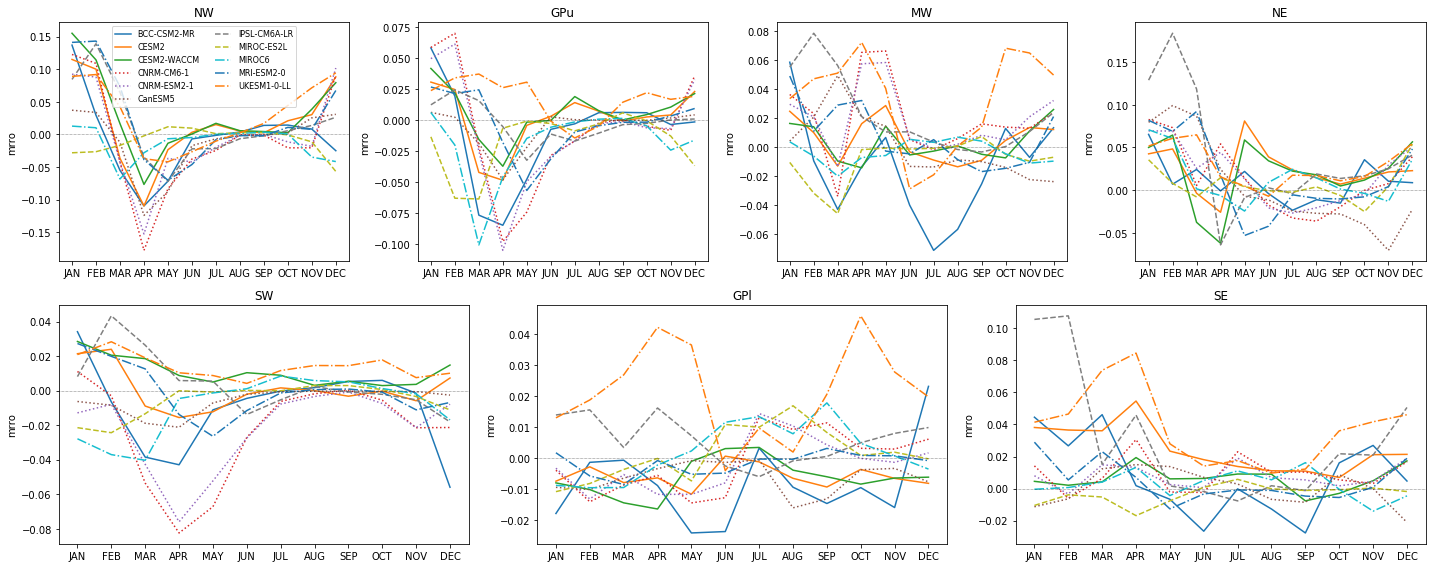

In [428]:
plot_model_trends("mrro")

NW
GPu
MW
NE
SW
GPl
SE


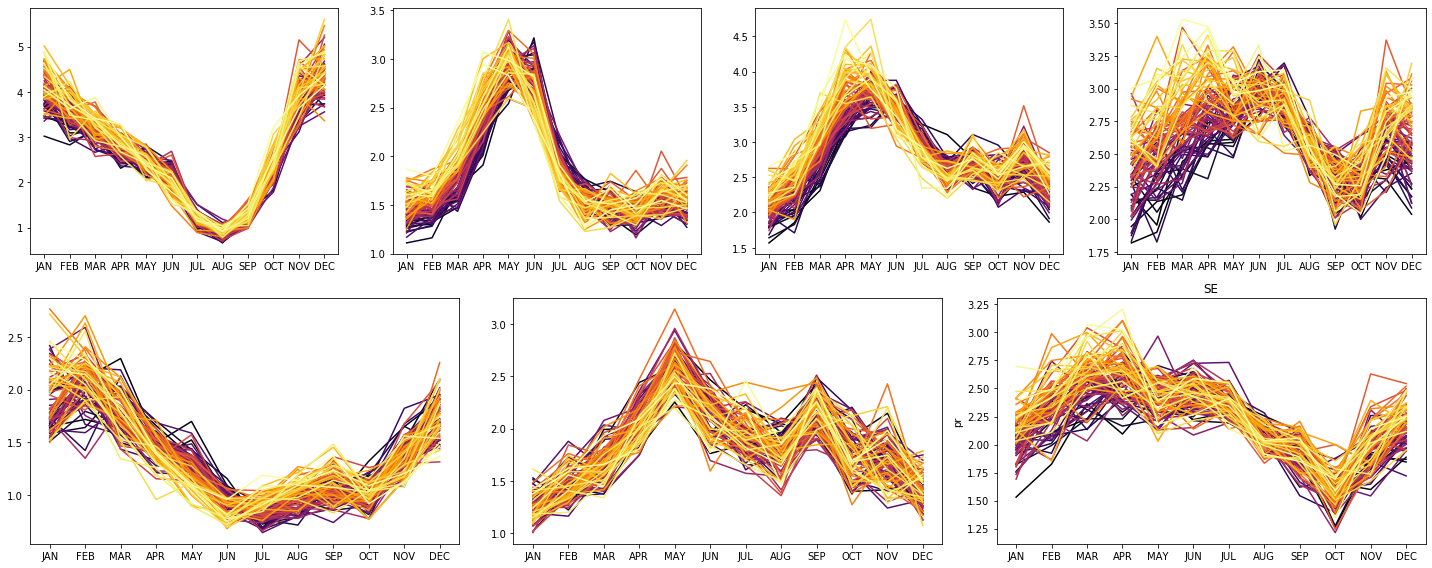

In [344]:
plot_seasonal_trends("pr")

NW
GPu
MW
NE
SW
GPl
SE


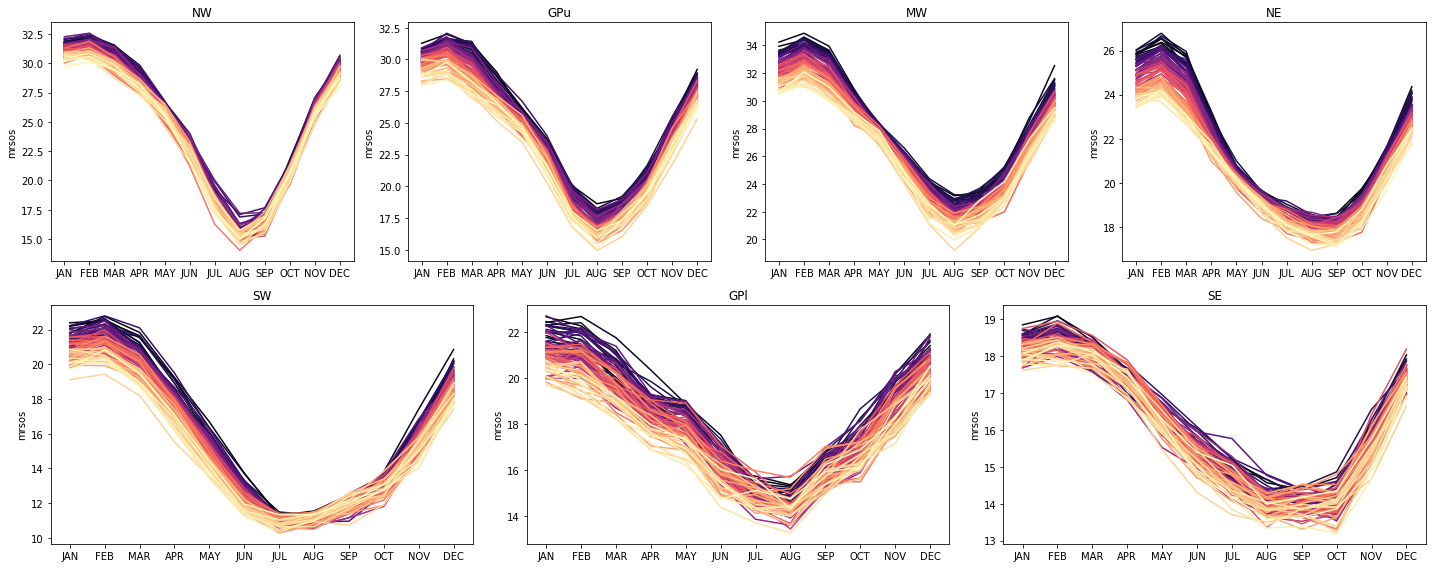

In [346]:
plot_seasonal_trends("mrsos")

NW
GPu
MW
NE
SW
GPl
SE


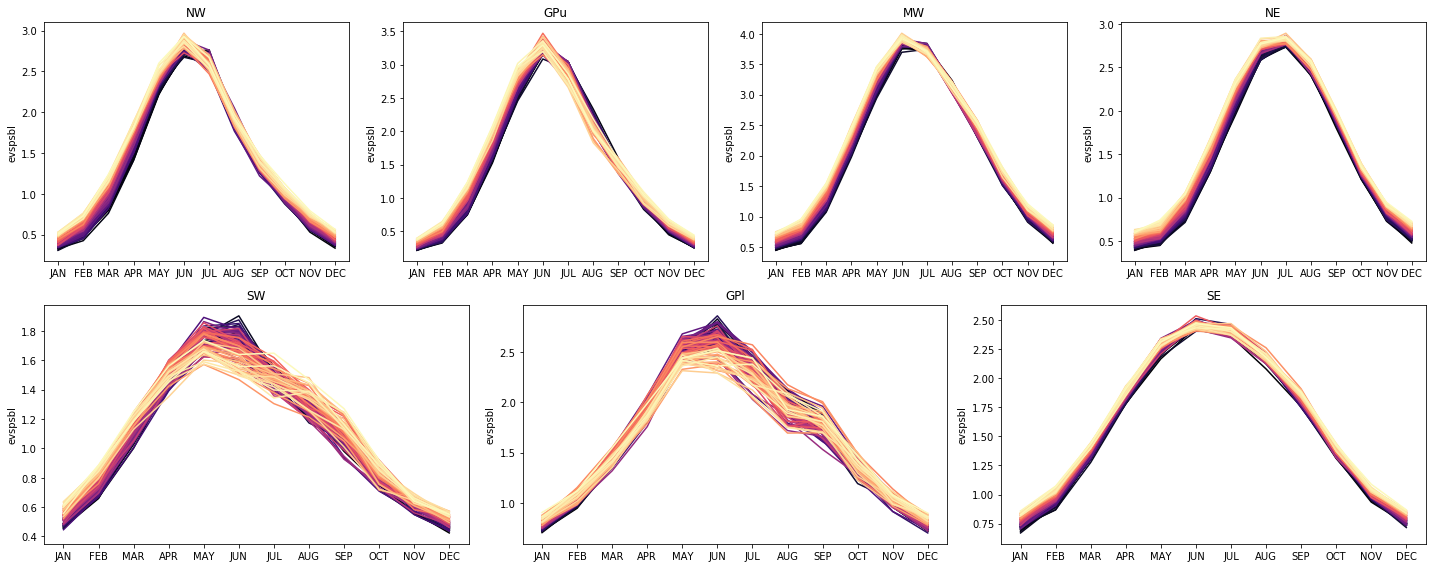

In [399]:
plot_seasonal_trends("evspsbl")

NW
GPu
MW
NE
SW
GPl
SE
NW
GPu
MW
NE
SW
GPl
SE
NW
GPu
MW
NE
SW
GPl
SE
NW
GPu
MW
NE
SW
GPl
SE
NW
GPu
MW
NE
SW
GPl
SE
NW
GPu
MW
NE
SW
GPl
SE
NW
GPu
MW
NE
SW
GPl
SE
NW
GPu
MW
NE
SW
GPl
SE


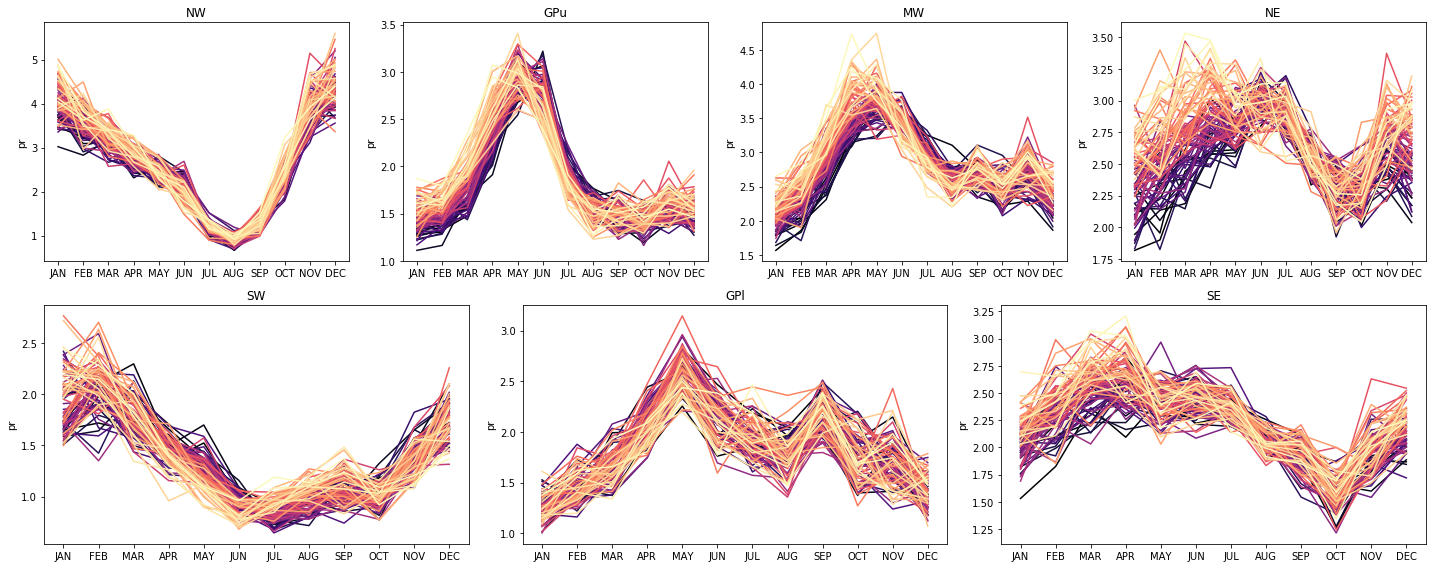

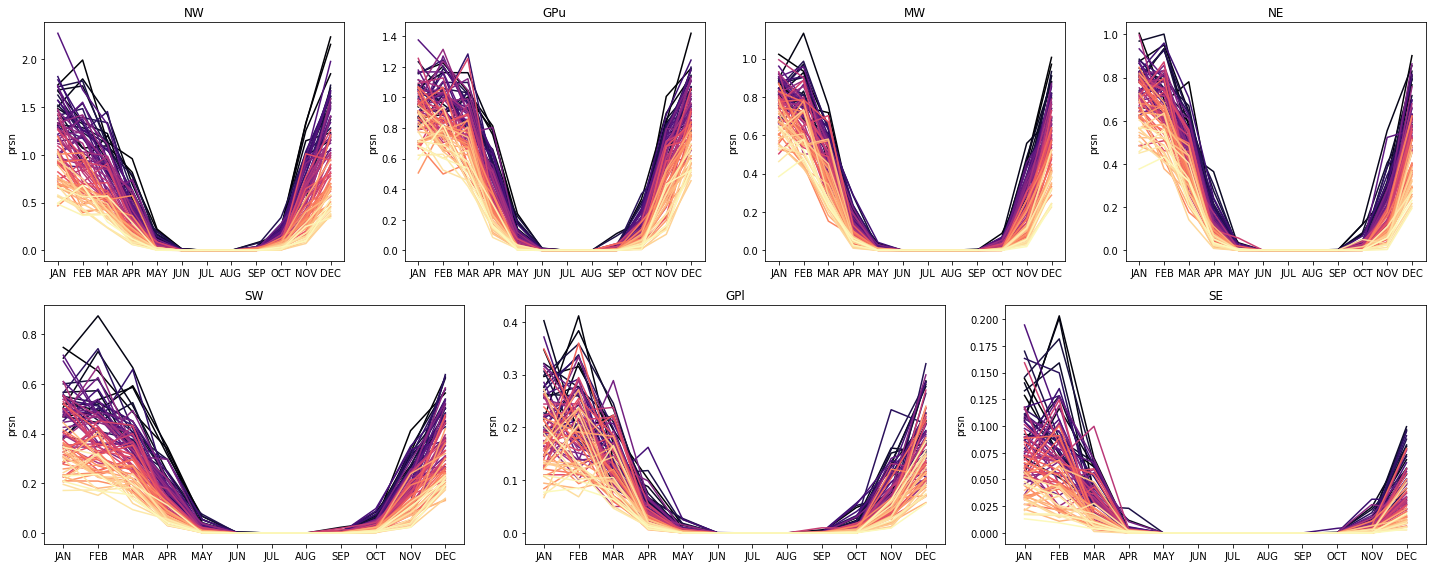

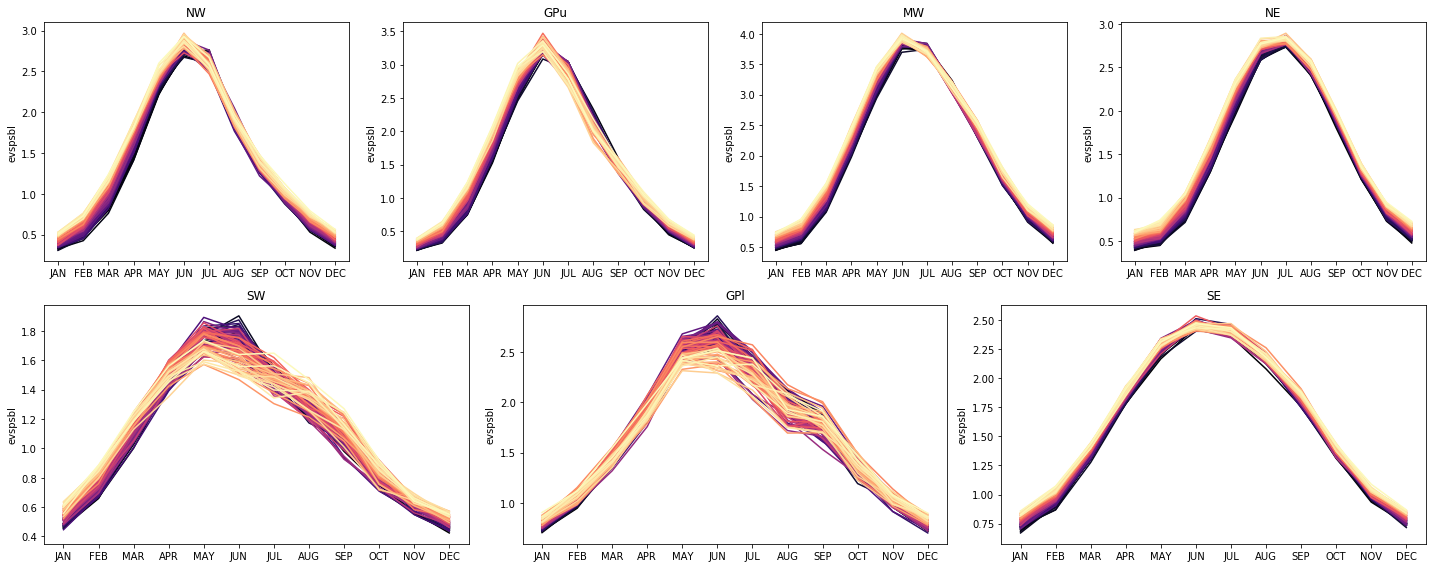

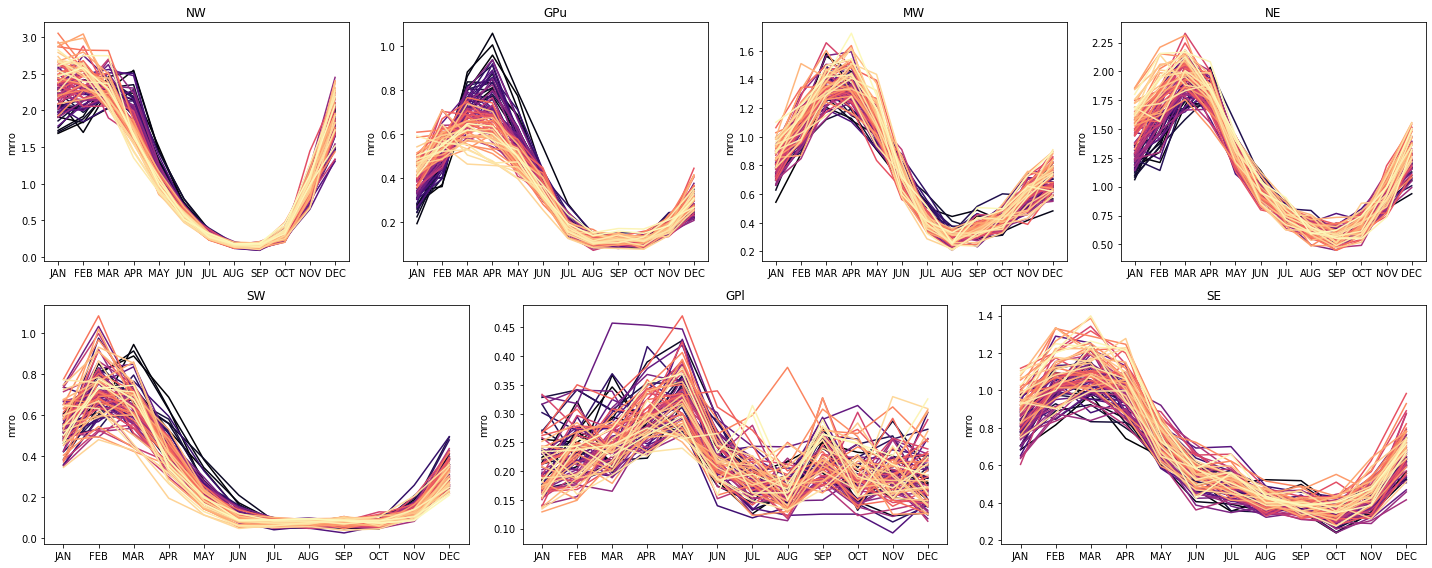

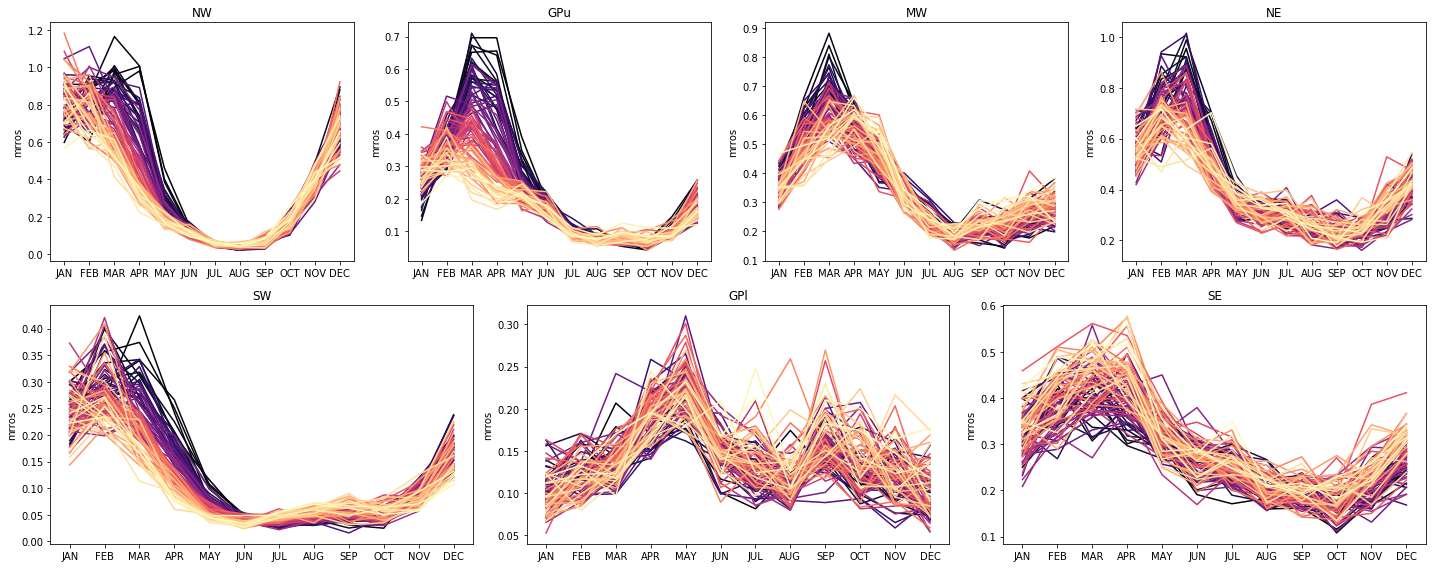

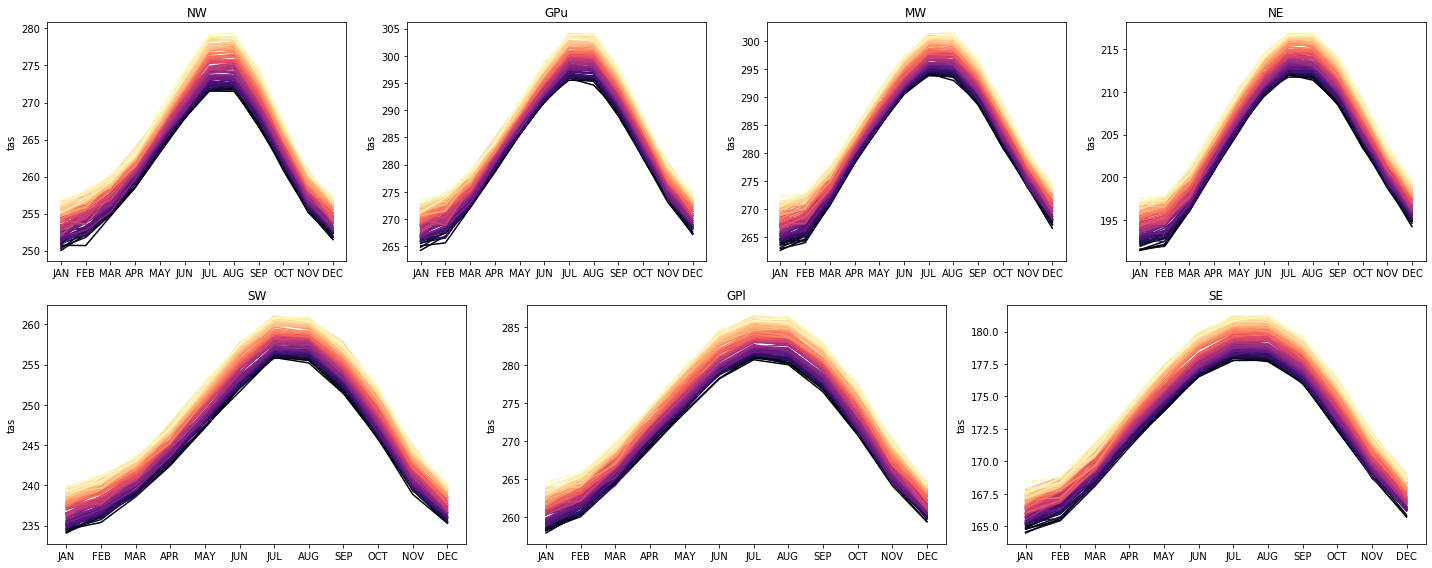

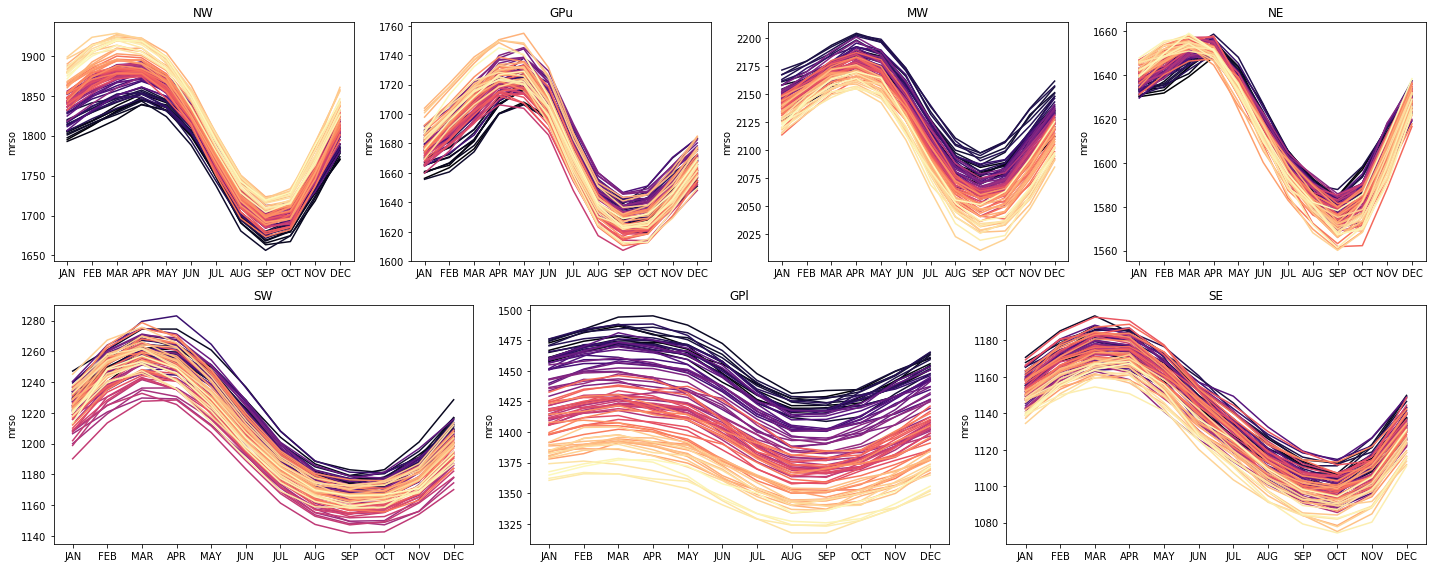

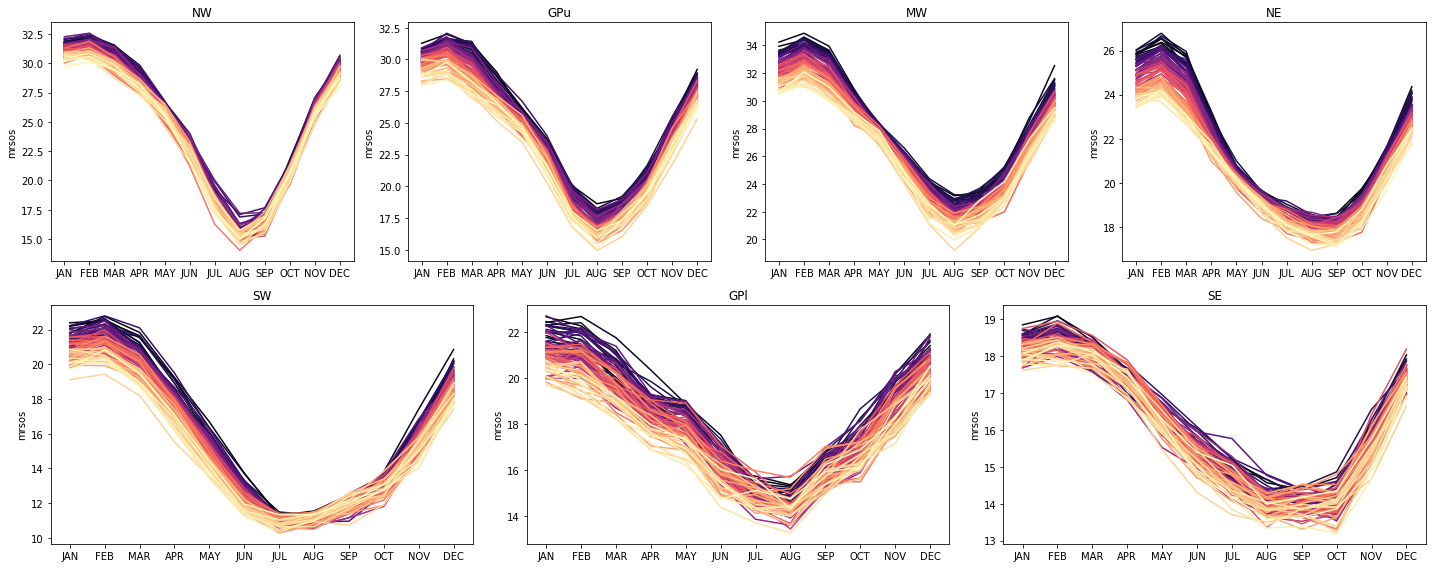

In [400]:
variables=["pr","prsn","evspsbl","mrro","mrros","tas","mrso","mrsos"]
for variable in variables:
    plot_seasonal_trends(variable)
    plt.savefig("ACFIGS/"+variable+".png")

/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/numpy/ma/core.py:3201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


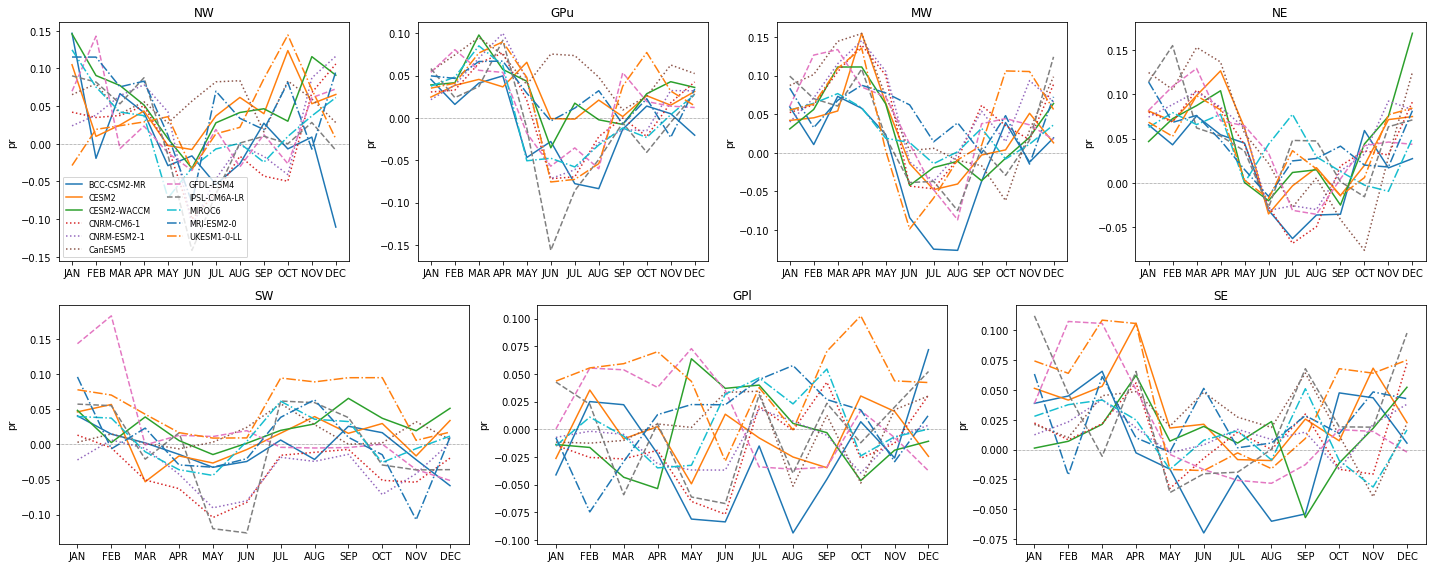

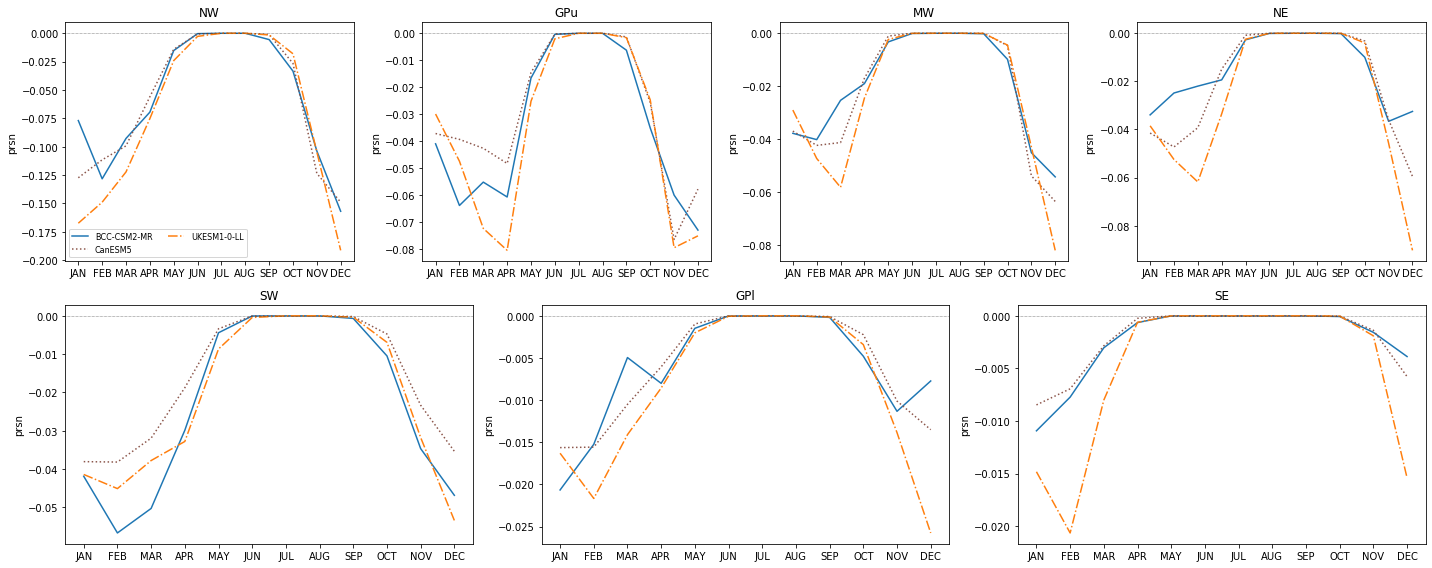

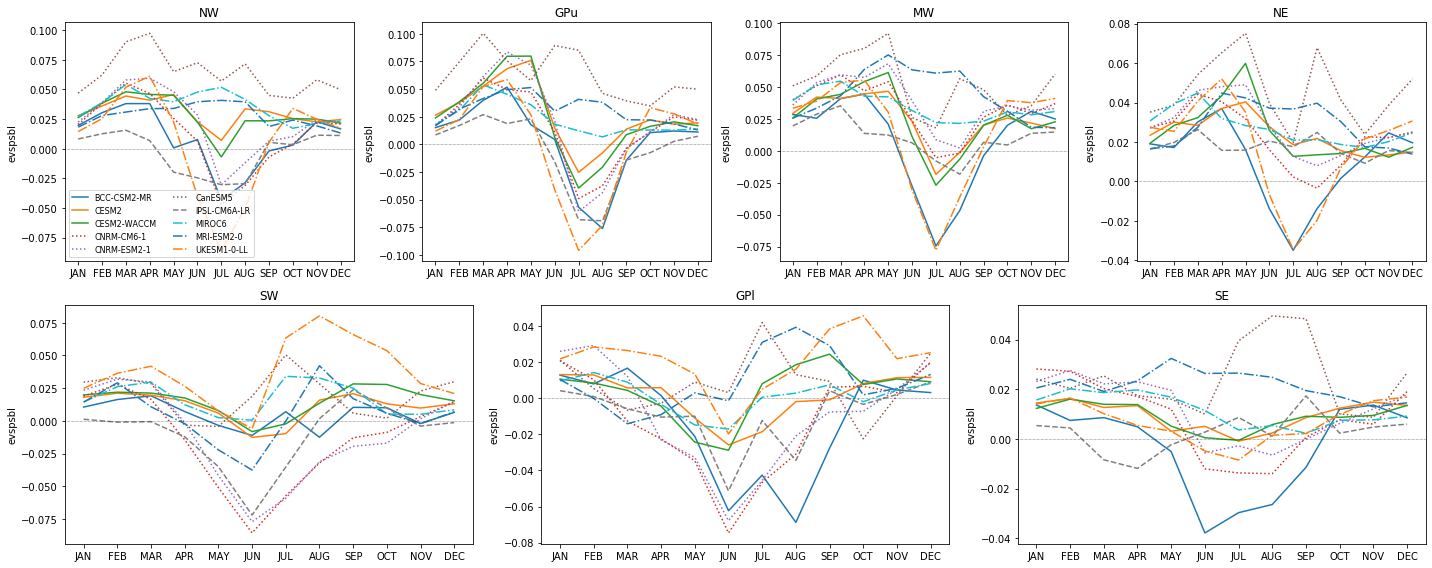

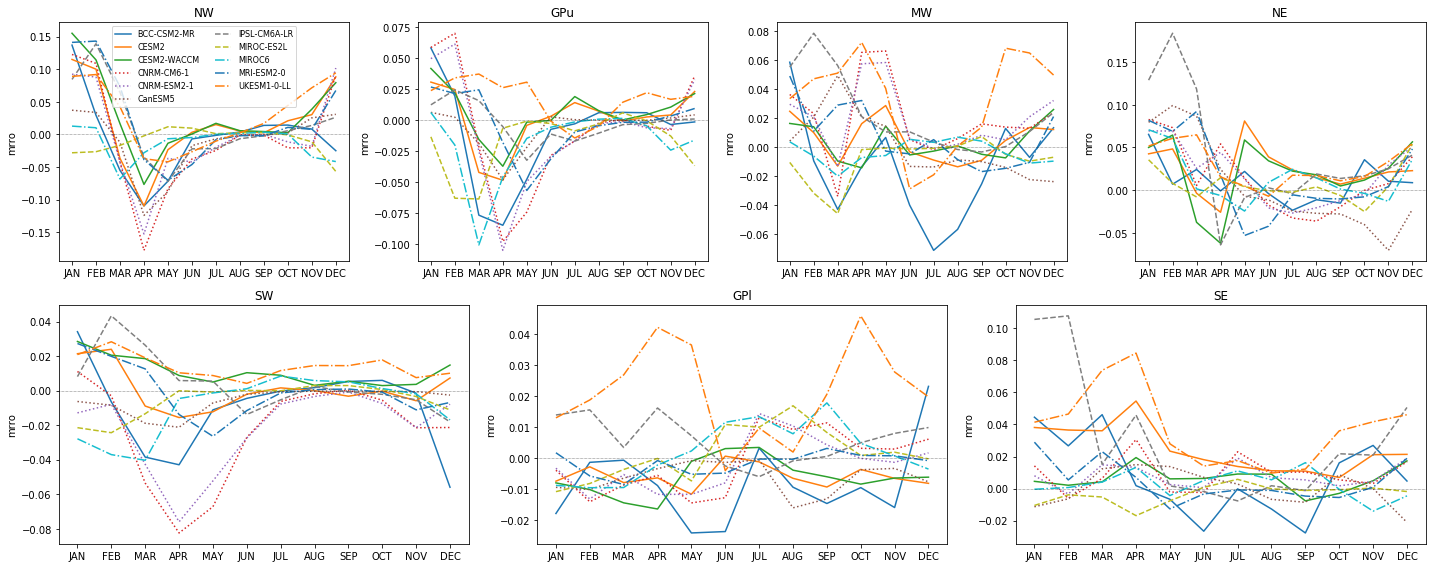

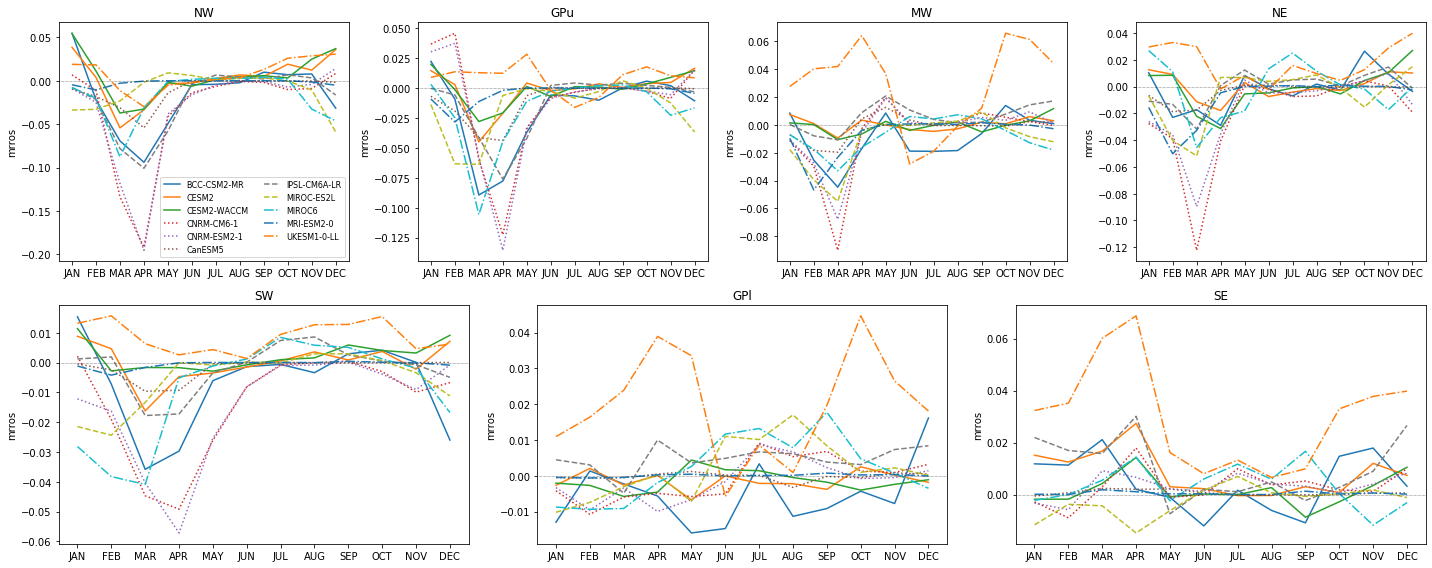

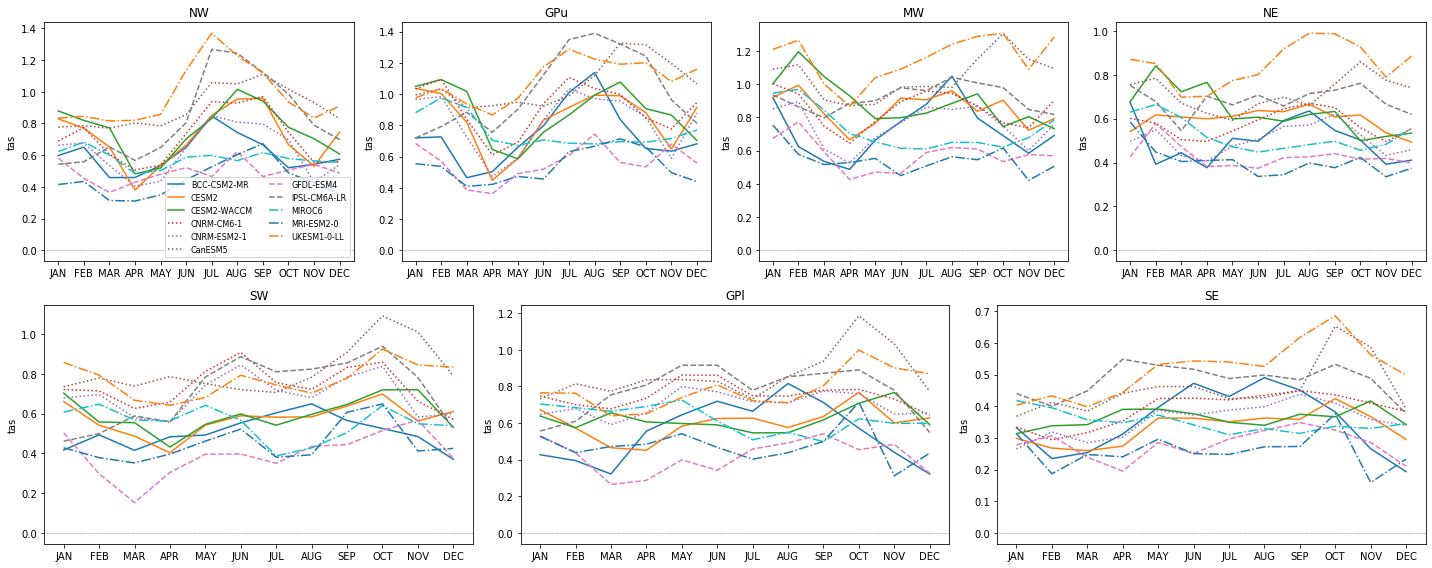

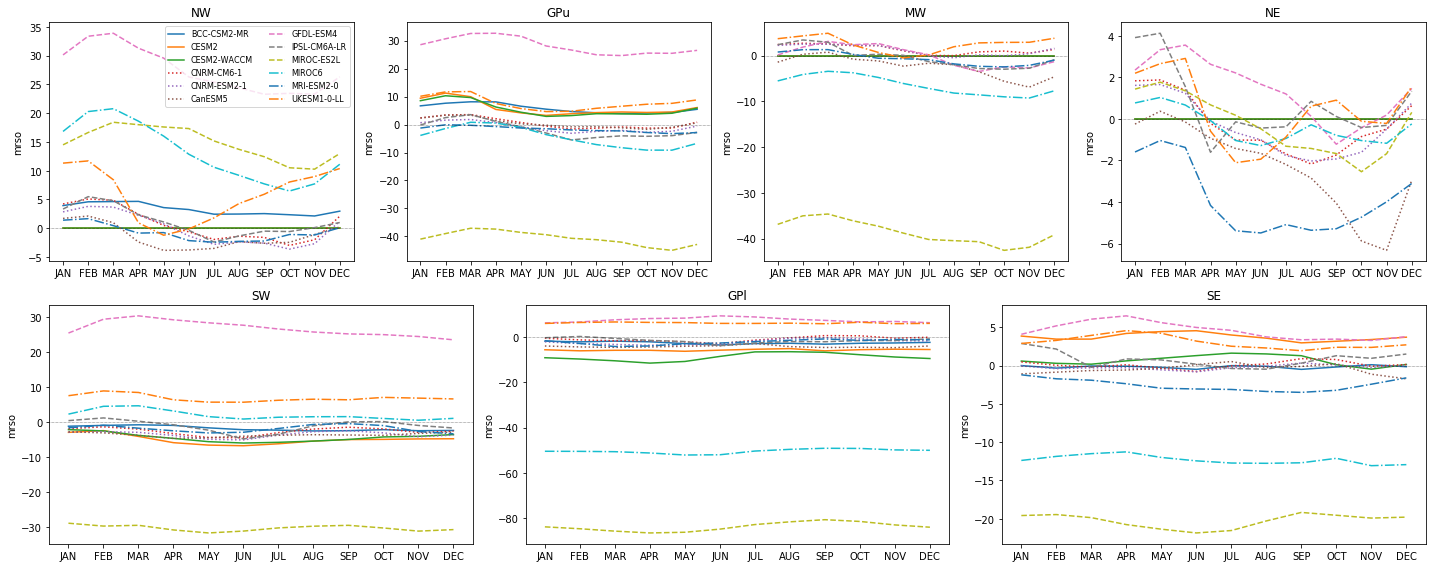

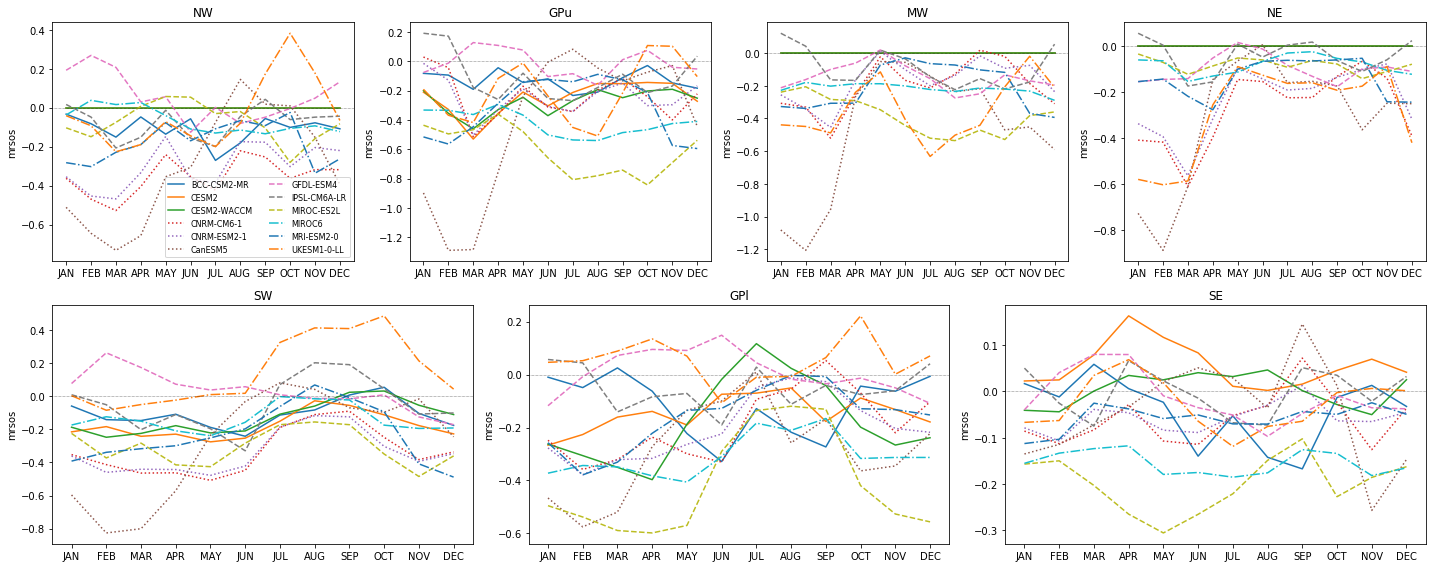

In [429]:
variables=["pr","prsn","evspsbl","mrro","mrros","tas","mrso","mrsos"]
for variable in variables:
    plot_model_trends(variable)
    plt.savefig("TRENDFIGS/"+variable+".png")

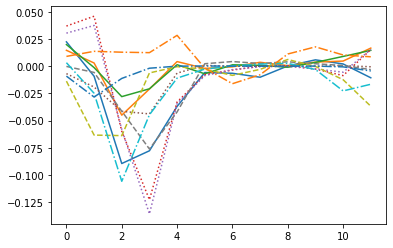

In [420]:

months=["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
nmod=test.shape[0]
trends=np.zeros((nmod,12))
models=cmip5.models(test)
for i in range(12):
    month=months[i]
    mdat=getattr(cdutil,month).departures(test)
    #model=models[i]
    #c=get_model_colors(model)
    #ls=get_model_ls(model)
    #plt.plot(np.arange(12),cmip5.get_linear_trends(mdat).asma(),c=c,ls=ls)
    trends[:,i]=cmip5.get_linear_trends(mdat)
trends=MV.array(trends)

trends.setAxis(0,test.getAxis(0))
for i in range(nmod):
    model=models[i]
    c=get_model_colors(model)
    ls=get_model_ls(model)
    plt.plot(np.arange(12),trends[i].asma(),c=c,ls=ls,label=model)


[[<matplotlib.lines.Line2D at 0x7fdbf6bf1f28>],

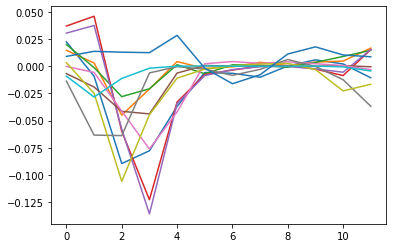

array(['APR', 'MAR', 'MAY'], dtype='<U3')

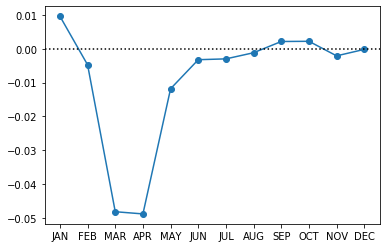

In [397]:
plt.plot(trends,"o-")
plt.axhline(0,c="k",ls=":")
tcks=plt.xticks(range(12),months)
atrends=np.abs(trends)
biggest=np.argmax(atrends)
biggest
if atrends[biggest-1]> atrends[biggest+1]:
    next_biggest=biggest-1
    other=biggest+1
    check=biggest-2
else:
    next_biggest=biggest+1
    other=biggest-1
    check=biggest+2

if atrends[check]>atrends[other]:
    three_biggest=[biggest,next_biggest,check]
else:
    three_biggest=[biggest,next_biggest,other]
np.array(months)[np.array(three_biggest)]


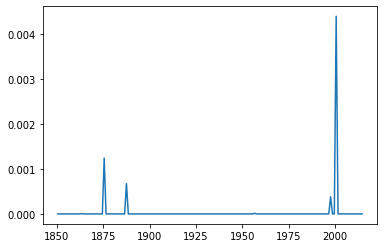

In [228]:

f=cdms.open("/Users/kmarvel/Documents/DATA/dester/regional_averages/NCA4/SW/mrros/historical/mrros.historical.MRI-ESM2-0.r1i1p1f1.nc")
mrrosfromfile=f("mrros")
cdutil.setTimeBoundsMonthly(mrrosfromfile)
Plotting.time_plot(cdutil.JJA(mrrosfromfile))

In [ ]:
sns_mrros_cp_djf=MRROS_CP.plot_signal_to_noise("DJF")

In [ ]:
#try with new noise calc
sns_mrros_cp_djf=MRROS_CP.plot_signal_to_noise("DJF")

In [8]:
#variables=["pr","evspsbl","mrro","mrros","mrso","mrsos","tas"]
variables=["mrsos","tas"]
seasons=["DJF","MAM","JJA","SON"]
writedirec="/Users/kmarvel/Documents/DATA/dester/SN/"
for variable in variables:
    CP=TOE(variable,"central_plains")
    SW=TOE(variable,"southwest")
    for season in seasons:
        plt.figure()
        SN_CP=CP.plot_signal_to_noise(season)
        plt.title("Central Plains ("+season+")")
        plt.savefig(variable+".central_plains."+season+".SN.png")
        writehere=writedirec+"central_plains/"
        for ssp in SN_CP.keys():
            data=SN_CP[ssp]
            data.id=variable+"_SN"
            
            writefname=variable+"."+ssp+".central_plains."+season+".SN.nc"
            fw=cdms.open(writehere+writefname,"w")
            fw.write(data)
            fw.close()
       
        
        plt.clf()
        
        #plt.figure()
        SN_SW=SW.plot_signal_to_noise(season)
        plt.title("Southwest ("+season+")")
        plt.savefig(variable+".southwest."+season+".SN.png")
        writehere=writedirec+"southwest/"
        for ssp in SN_SW.keys():
            data=SN_SW[ssp]
            data.id=variable+"_SN"
            
            writefname=variable+"."+ssp+".southwest."+season+".SN.nc"
            fw=cdms.open(writehere+writefname,"w")
            fw.write(data)
            fw.close()
        
        
       
        
        plt.clf()

        

/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/numpy/ma/core.py:3201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
f=cdms.open(writehere+writefname)
test=f("pr_SN")
Plotting.time_plot(MV.average(test,axis=0))

In [ ]:
variables=["pr","evspsbl","mrro","mrros","mrso","mrsos","pr","prsn","tas"]
CENTRAL_PLAINS_SN={}
SOUTHWEST_SN={}
for variable in variables:
    CP=TOE(variable,"central_plains")
    SW=TOE(variable,"southwest")
    CENTRAL_PLAINS_SN[variable]=CP.plot_signal_to_noise("JJA")
    plt.title("Central Plains (JJA)")
    plt.savefig(variable+".central_plains.JJA.SN.png")
    plt.clf()
    SOUTHWEST_SN[variable]=SW.plot_signal_to_noise("JJA")
    plt.title("Southwest (JJA)")
    plt.savefig(variable+".southwest.JJA.SN.png")
    

In [ ]:
f=cdms.open("/Users/kmarvel/Documents/DATA/dester/regional_averages/central_plains/prsn/ssp126/prsn.ssp126.BCC-CSM2-MR.r1i1p1f1.nc")

In [ ]:
SNS=MRSOS_SW.plot_signal_to_noise("JJA")

In [ ]:
CENTRAL_PLAINS_SN.keys()

In [ ]:
def draw_SN(variable,region,save=True):
    if region == "central_plains":
        D=CENTRAL_PLAINS_SN
    else:
        D=SOUTHWEST_SN
  
    for ssp in sorted(D[variable].keys()):

        SN=D[variable][ssp]
        if variable in ["pr","evspsbl","prsn","mrros","mrro"]:
            SN = SN/86400.
        Plotting.time_plot(MV.average(SN,axis=0),label=get_label(ssp),color=get_color(ssp))
    if MV.average(SN,axis=0)[-1]>0:
        thresh=stats.norm.interval(.99)[1]
    else:
        thresh=stats.norm.interval(.99)[0]
    plt.axhline(thresh,c="k",ls=":",lw=.5,label="\"Virtually Certain\" threshold")
    plt.legend(fontsize=8)
    plt.title(region+ " (JJA)")
    plt.xlabel("Trend End Year (assuming 1980 start)")
    plt.ylabel(variable+" S/N")
    if save:
        plt.savefig(variable+"."+region+".JJA.SN.png")
draw_SN("mrros","central_plains",save=False)
plt.figure()
draw_SN("mrros","southwest",save=False)

In [ ]:
signals370=MRSOS_CP.signals("JJA","ssp370")

In [ ]:
signals126=MRSOS_CP.signals("JJA","ssp126")

In [ ]:
signals245=MRSOS_CP.signals("JJA","ssp245")

In [ ]:
noise=MRSOS_CP.noise("JJA")

In [ ]:
SN=cmip5.cdms_clone(signals.asma()/noise.asma(),signals)
SN7=cmip5.cdms_clone(signals370.asma()/noise.asma(),signals)
SN26=cmip5.cdms_clone(signals126.asma()/noise.asma(),signals)
SN45=cmip5.cdms_clone(signals245.asma()/noise.asma(),signals)

In [ ]:
Plotting.time_plot(MV.average(SN,axis=0),label="SSP5-8.5",color=get_color("ssp585"))
Plotting.time_plot(MV.average(SN7,axis=0),label="SSP3-7.0",color=get_color("ssp370"))
Plotting.time_plot(MV.average(SN26,axis=0),label="SSP1-2.6",color=get_color("ssp126"))
Plotting.time_plot(MV.average(SN45,axis=0),label="SSP2-4.5",color=get_color("ssp245"))
plt.axhline(stats.norm.interval(.99)[0],c="k",ls=":",lw=.5,label="\"Virtually Certain\" threshold")
plt.legend()
dettime=lambda SN: SN.getTime().asComponentTime()[np.min(np.where(np.abs(MV.average(SN,axis=0))>stats.norm.interval(.99)[1])[0])]
plt.xlabel("Trend End Year (assuming 1980 start)")
plt.ylabel("Surface soil moisture S/N")
plt.savefig("MRSOS_SN.png")

In [ ]:
print(SingleMember.shape)
print(jja.shape)
print(jjanc.shape)

In [ ]:
5988./12.

In [ ]:
MRSOS_CP.plot_future("JJA",single_member=True)

In [ ]:
MRSOS_CP.plot_future("JJA",single_member=False)

In [ ]:
models=sorted(self.ensemble_dict.keys())
        nmod=len(models)
        SingleMember=np.ma.zeros((nmod,ntime))
        fnames=get_ensemble_filenames(self.variable,self.region,experiment)
        counter=0
        for model in models:
            fnames=np.array(get_ensemble_filenames(self.variable,self.region,experiment))
            I=np.where(sorted([x.split(".")[2]==model for x in fnames]))[0]
            first_member=I[0]
            SingleMember[counter]=data.asma()[first_member]
            counter+=1

In [ ]:
fnames

In [ ]:
Plotting.time_plot(piC[1])

In [75]:
def get_averages(region,variable,experiment):
    readstem="/Volumes/SahelData/CMIP6Drought/NCA4/"
   
   
   
    readdirec=readstem+region+"/"+variable+"/"+experiment+"/"

    fnames=glob.glob(readdirec+"*r1i1p1*")
    nfiles=len(fnames)
    i=0
    fil=fnames[i]
    f=cdms.open(fil)
    data=f(variable)
    tax=data.getTime()
    ntime=len(tax)
    alldata=MV.zeros((nfiles,ntime))+1.e20
    alldata[i]=data
    for i in range(nfiles)[1:]:
        fil=fnames[i]
        f=cdms.open(fil)
        data=f(variable)
        if len(data.getTime())==ntime:
            alldata[i]=data
        f.close()
        
    alldata.setAxis(1,tax)    
    modax=cmip5.make_model_axis(fnames)
    alldata.setAxis(0,modax)
    return MV.masked_where(alldata==0,MV.masked_where(np.abs(alldata)>1.e10,alldata))

In [76]:
def plot_season(data,season,**kwargs):
    avg=MV.average(data,axis=0)
    cdutil.setTimeBoundsMonthly(avg)
    Plotting.time_plot(getattr(cdutil,season)(avg),**kwargs)

In [77]:
class Averages():
    def __init__(self,variable,region):
        models={}
        readstem="/Volumes/SahelData/CMIP6Drought/NCA4/"
        experiments=[x.split("/")[-1] for x in glob.glob(readstem+region+"/"+variable+"/*")]
        for experiment in experiments:
            readdirec=readstem+region+"/"+variable+"/"+experiment+"/"
            rips=[x.split(".")[3] for x in glob.glob(readdirec+"*")]
            models[experiment]=np.unique([x.split(".")[2] for x in glob.glob(readdirec+"*")])
        okmodels=models[experiments[0]]
        for experiment in experiments[1:]: 
            #FIX THIS WHEN piCONTROL DOWNLOADS
            if experiment != "piControl":
                okmodels=np.intersect1d(okmodels,models[experiment])
                
        
        self.variable=variable
        self.models=okmodels
        
        self.historical=get_averages(region,variable,"historical")

        self.ssp585=get_averages(region,variable,"ssp585")

        self.ssp370=get_averages(region,variable,"ssp370")

        self.ssp126=get_averages(region,variable,"ssp126")
        self.ssp245=get_averages(region,variable,"ssp245")
    def plot_all(self,season):
        plot_season(self.ssp585,season,label="8.5")
        plot_season(self.ssp370,season,label="7.0")
        plot_season(self.ssp245,season,label="4.5")
        plot_season(self.ssp126,season,label="1.6")
        plt.legend()
        plt.title(self.variable)

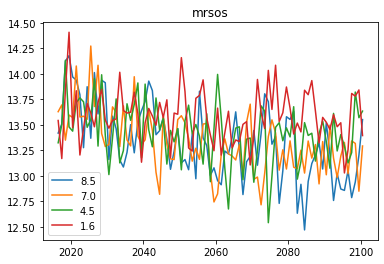

In [80]:
TAS=Averages("mrsos","SW")
TAS.plot_all("JJA")

In [ ]:
PR=Averages("pr")
MRROS=Averages("mrros")
MRSO = Averages("mrso")
MRSOS = Averages("mrsos")

In [ ]:
EV = Averages("evspsbl")

In [ ]:
plt.figure()
TAS.plot_all("JJA")
plt.figure()
PR.plot_all("JJA")
plt.figure()
MRROS.plot_all("JJA")
plt.figure()
MRSO.plot_all("JJA")
plt.figure()
MRSOS.plot_all("JJA")
plt.figure()
EV.plot_all("JJA")

In [ ]:
#def concatenate_piControl():
readstem="/Users/kmarvel/Documents/DATA/dester/regional_averages/"
readdirec=readstem+region+"/"+variable+"/piControl/"
fnames=glob.glob(readdirec+"*")
    nfiles=len(fnames)
    i=0
    fil=fnames[i]
    f=cdms.open(fil)
    data=f(variable)
    tax=data.getTime()
    ntime=len(tax)
    alldata=MV.zeros((nfiles,ntime))
    alldata[i]=data
    for i in range(nfiles)[1:]:
        fil=fnames[i]
        f=cdms.open(fil)
        data=f(variable)[:ntime]
        alldata[i]=data
        f.close()
        
    alldata.setAxis(1,tax)    
    modax=cmip5.make_model_axis(fnames)
    alldata.setAxis(0,modax)
    return alldata